<a href="https://colab.research.google.com/github/AhamedShimak/My_GANs/blob/main/MakeMe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number generator

###imports

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split

###GPU 

In [3]:
!nvidia-smi
print(torch.cuda.is_available())
#setup device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)


/bin/bash: nvidia-smi: command not found
False
cpu


# Load Dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2

def convert_video_to_images(video_path, output_path):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = video_capture.read()
        if not success:
            break

        output_file = f"{output_path}/{frame_count}.jpg"
        cv2.imwrite(output_file, frame)

        frame_count += 1

    video_capture.release()

# Usage example

convert_video_to_images("/content/drive/MyDrive/AI/shimak.mp4", output_path="/content/drive/MyDrive/AI/shimak")



###data transforms / for good perfomance

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize image to (224, 224)
    #transforms.TrivialAugmentWide(2),

    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.RandomHorizontalFlip(0.5) # Normalize image tensor
])

In [7]:
from torchvision import datasets
trainset=datasets.ImageFolder(root="/content/drive/MyDrive/AI/data",transform=data_transform, target_transform=None)

1302

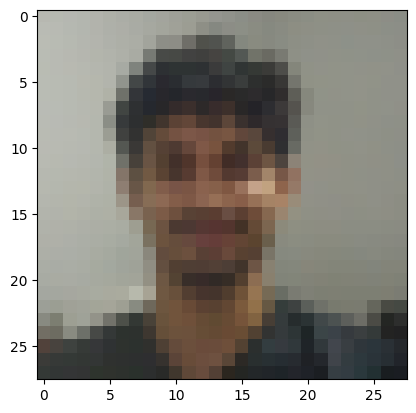

In [8]:
image,label=trainset[7]
plt.imshow(image.squeeze().permute(1,2,0))
len(trainset)

# Data load / batch ready!

In [9]:
batch_size=128

In [10]:
trainloader=DataLoader(trainset,batch_size=batch_size, shuffle=True)

In [11]:
len(trainloader)

11

torch.Size([3, 28, 28])
tensor(0)


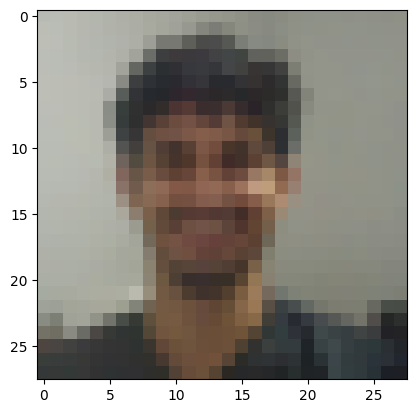

In [12]:
images, label = next(iter(trainloader))
print(images[0].shape)
#print(images[0])
plt.imshow(images[0].permute(1,2,0))
print(label[0])

In [13]:
# plot in sub plots //grayscale

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

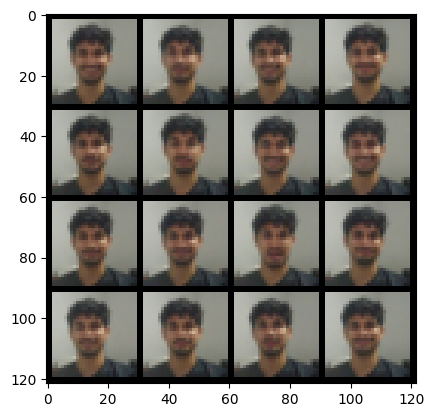

In [14]:
show_tensor_images(images)

# Building the model | Discriminator

In [16]:
def get_disc_block(in_channels, out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0,2)
  )

In [28]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 =get_disc_block(3,16,(3,3),2)
    self.block_2 =get_disc_block(16,32,(5,5),2)
    self.block_3 =get_disc_block(32,64,(5,5),2)

    self.classifier=nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 64,out_features=1)
    )
  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.block_3(self.block_2(self.block_1(x))))

In [29]:
D= Discriminator()
D.to(device)
summary(D, input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             448
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,833
Trainable params: 64,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

# Create Generator Network 

In [19]:
def get_gen_block(in_channels, out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [32]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim=noise_dim
    self.block_1 =get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 =get_gen_block(256,128,(4,4),1)
    self.block_3 =get_gen_block(128,64,(3,3),2)

    self.image_gen_block=nn.Sequential(
        nn.ConvTranspose2d(64,3,(4,4),2),
        nn.Tanh()
    )
  def forward(self, r_noise_dim):
    x= r_noise_dim.view(-1,self.noise_dim,1,1)
    return self.image_gen_block(self.block_3(self.block_2(self.block_1(x))))

In [33]:
noise_dim=128
G= Generator(noise_dim)
G.to(device)
summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         295,168
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 3, 28, 28]           3,075
             Tanh-11            [-1, 3, 28, 28]               0
Total params: 897,347
Trainable params: 897,347
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [34]:
# Replace Random initialized weights to Normal weights  
def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [35]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [36]:
# optim para

lr=0.01
beta_1=0.5
beta_2=0.99



In [37]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 | D_loss:0.688853616064245 | G_loss0.6950461322611029


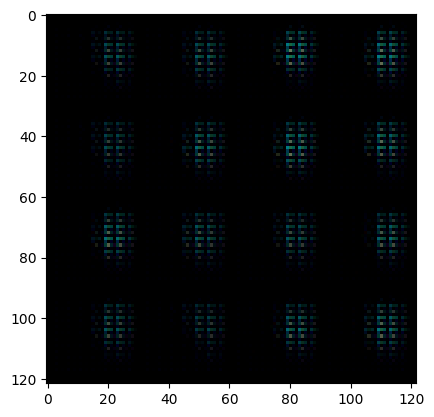

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2 | D_loss:0.6601075855168429 | G_loss0.7504527243700895


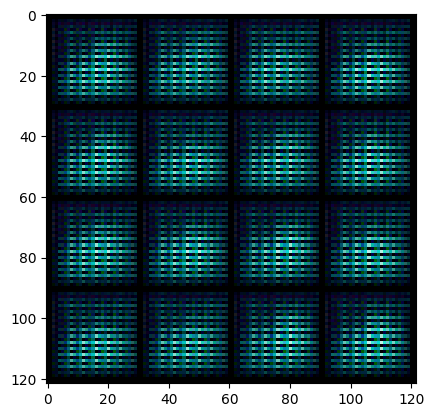

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3 | D_loss:0.5847552852197127 | G_loss0.9041812365705316


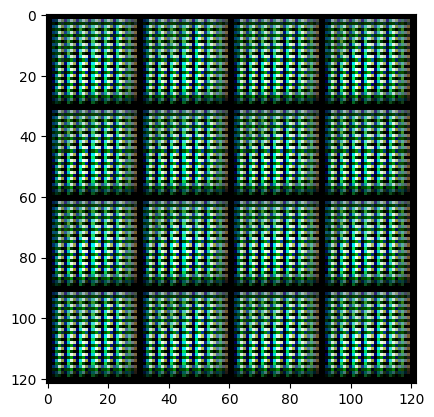

In [ ]:
def real_loss(disc_pred):
  loss_func=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred) #creating zeros with matching size of disc_pred
  loss =loss_func(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  loss_func=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred) #creating zeros with matching size of disc_pred
  loss =loss_func(disc_pred,ground_truth)
  return loss

#training_var
epochs=20

for  i in range(epochs):
  total_d_loss=0.0
  total_g_loss=0.0

  for real_img, _ in tqdm(trainloader):
    real_img= real_img.to(device)
    noise=torch.randn(batch_size,noise_dim,device = device)

    #pred_discriminator
    fake_img=G(noise)
    D_pred=D(fake_img)

    #loss_calculation
    D_loss_to_increase=fake_loss(D_pred)

    D_pred=D(real_img)
    D_loss_to_reduce=real_loss(D_pred)

    
    D_loss=(D_loss_to_increase + D_loss_to_reduce)/2

    total_d_loss += D_loss.item()


    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()

    #generator_side #################################
    noise=torch.randn(batch_size,noise_dim,device = device)

    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()
  
  avg_d_loss=total_d_loss/len(trainloader)
  avg_g_loss=total_g_loss/len(trainloader)

  print("Epoch: {} | D_loss:{} | G_loss{}".format(i+1, avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)

##EVALUATION

In [ ]:
show_tensor_images(fake_img)

In [ ]:
#Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)
show_tensor_images(generated_image)